In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import warnings

from matplotlib import pyplot as plt
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter( 'ignore', SettingWithCopyWarning )

from IPython.core.display import HTML

def css_styling():
    styles = open( '../styles/custom.css', 'r' ).read()
    return HTML( styles )

css_styling()

In [2]:
# Import radon data
srrs2 = pd.read_csv( '../dataset/srrs2.dat')
srrs2.columns = srrs2.columns.map(str.strip)
srrs_mn = srrs2[srrs2['state'] == 'MN']

In [3]:
srrs_mn['fips'] = srrs_mn['stfips']*1000 + srrs_mn['cntyfips']
cty = pd.read_csv( '../dataset/cty.dat' )
cty_mn = cty[cty['st'] == 'MN']
cty_mn['fips'] = 1000*cty_mn['stfips'] + cty_mn['ctfips']

In [4]:
srrs_mn = srrs_mn.merge( cty_mn[['fips', 'Uppm']], on='fips' )
srrs_mn = srrs_mn.drop_duplicates( subset='idnum' )
u = np.log( srrs_mn['Uppm'] )

n = len( srrs_mn )

In [5]:
srrs_mn['county'] = srrs_mn['county'].map( str.strip )
mn_counties = srrs_mn['county'].unique()
county_lookup = dict( zip( mn_counties, range( len( mn_counties) ) ) )

In [6]:
county = srrs_mn['county_code'] = srrs_mn['county'].replace( county_lookup ).values
radon = srrs_mn['activity']
srrs_mn['log_radon'] = log_radon = np.log( radon + 0.1 ).values
floor_measure = srrs_mn['floor'].values

## Distribution of radon levels in MN ( log scale )

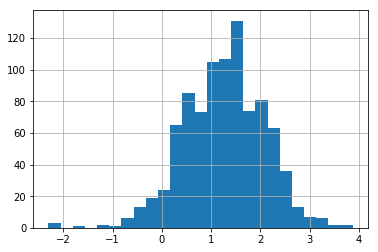

In [7]:
srrs_mn['activity'].apply( lambda x: np.log( x+0.1 ) ).hist( bins=25 )

## Complete Pooling model ( Traditional Regression Model )

In [8]:
from pymc3 import glm, Model, Metropolis, NUTS, sample

with Model() as pooled_model:
    glm.GLM.from_formula( 'log_radon ~ floor', srrs_mn )
    pooled_trace = sample( 1000, NUTS() )

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, floor, Intercept]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:03<00:00, 936.89draws/s] 


In [9]:
b0, m0 = pooled_trace['Intercept'][500:].mean(), pooled_trace['floor'][500:].mean()

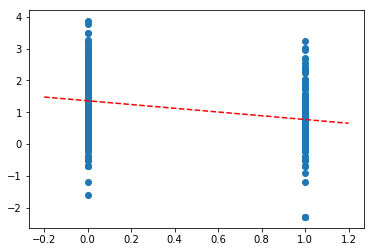

In [10]:
plt.scatter( srrs_mn['floor'], np.log(srrs_mn['activity']+0.1) )
xvals = np.linspace( -0.2, 1.2 )
plt.plot( xvals, m0*xvals+b0, 'r--' )

Estimates of county radon levels for the unpooled model:

In [17]:
from statsmodels.formula.api import ols
unpooled_fit = ols( 'log_radon ~ C(county) + floor - 1', srrs_mn ).fit()
unpooled_estimates = unpooled_fit.params

In [18]:
unpooled_estimates = unpooled_estimates.rename(dict(zip(unpooled_estimates.index.values, [x[10:-1] or x for x in unpooled_estimates.index.values] )))
unpooled_se = unpooled_fit.HC3_se.rename(dict(zip(unpooled_fit.HC3_se.index.values, [x[10:-1] or x for x in unpooled_fit.HC3_se.index.values])))

We can plot the ordered estimates to identify counties with high radon levels:

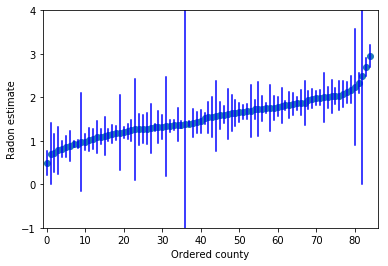

In [26]:
order = unpooled_estimates.sort_values()[1:].index

plt.scatter(range(len(unpooled_estimates)-1), unpooled_estimates[order])
for i, m, se in zip(range(len(unpooled_estimates)-1), unpooled_estimates[order], unpooled_se[order]):
    plt.plot( [i,i], [m-se, m+se], 'b-')
plt.xlim( -1, 86 ); plt.ylim(-1, 4 )
plt.ylabel( 'Radon estimate' ); plt.xlabel( 'Ordered county' );


Here a visual comparison between the pooled and unpooled estimates for a subset of counties representing a range of samples size

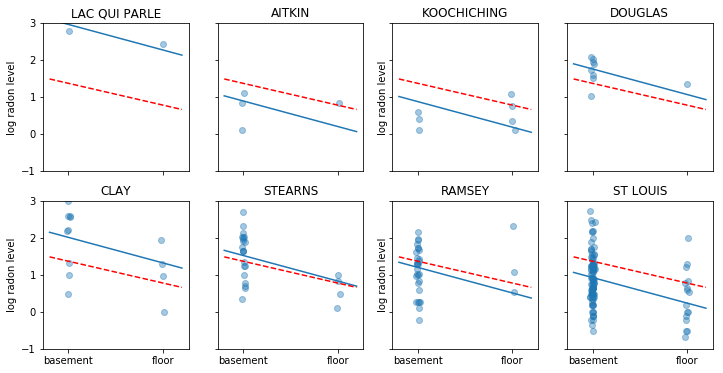

In [28]:
sample_counties = ( 'LAC QUI PARLE', 'AITKIN', 'KOOCHICHING', 
                    'DOUGLAS', 'CLAY', 'STEARNS', 'RAMSEY', 'ST LOUIS')

fig, axes = plt.subplots( 2, 4, figsize=(12,6), sharey=True, sharex=True )
axes = axes.ravel()
for i, c in enumerate( sample_counties ):
    y = srrs_mn.log_radon[ srrs_mn.county == c ]
    x = srrs_mn.floor[srrs_mn.county == c ]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4 )
    
    # No pooling model
    m, b = unpooled_estimates[['floor', c]]
    
    # Plot both models and data
    xvals = np.linspace( -0.2, 1.2 )
    axes[i].plot( xvals, m*xvals+b )
    axes[i].plot( xvals, m0*xvals+b0, 'r--' )
    axes[i].set_xticks([0,1])
    axes[i].set_xticklabels(['basement', 'floor'])
    axes[i].set_ylim(-1, 3)
    axes[i].set_title( c )
    if not i%2:
        axes[i].set_ylabel( 'log radon level' )

## Multilevel and hierarchical models

### Partial pooling model

In [29]:
from pymc3 import Normal, Model, Uniform

with Model() as partial_pooling:
    
    # Priors
    mu_a = Normal( 'mu_a', mu=0., tau=0.0001 )
    sigma_a = Uniform( 'sigma_a', lower=0, upper=100 )
    tau_a = sigma_a**-2
    
    # Random intercepts
    a = Normal( 'a', mu=mu_a, tau=tau_a, shape=len(set(county)))
    
    # Model error
    sigma_y = Uniform( 'sigma_y', lower=0, upper=100 )
    tau_y = sigma_y**-2
    
    # Expected value
    y_hat = a[county]
    
    # Data likelihood
    y_like = Normal( 'y_like', mu=y_hat, tau=tau_y, observed=log_radon )

In [30]:
from pymc3 import sample

with partial_pooling:
    
    step = NUTS()
    
    partial_pooling_samples = sample( 2000, step )

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_y, a, sigma_a, mu_a]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:16<00:00, 304.54draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [ ]:
sample_trace = partial_pooling_samples['a'][-1000:]

fig, axes = plt.subplots( 1, 2, figsize=(14,))